# Compare Observed and SoS-computed Discharge 

In [34]:
import os
import pandas
import xarray
import hsclient
import numpy as np
import earthaccess
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# import user credentials and set for earthaccess login
# this file contains two variables:
#    username='<username>'
#    password='<password>'
import creds

List the available community discharge datasets by querying HydroShare. We already know that these data are located in the following resource: https://www.hydroshare.org/resource/38feeef698ca484b907b7b3eb84ad05b. 

We can programatically access these data using the globally unique identifier found at the end of this url.

In [9]:
guid = '38feeef698ca484b907b7b3eb84ad05b'

Connect to HydroShare using the hsclient Python library. Since we're not using credentials, we'll only have access to public data.

In [5]:
hs = hsclient.HydroShare()

hsclient version: 1.1.2


Load this resource into memory and print metadata about it. This resource happens to contain references to other resources that contain the data we want. Display all of these associated resources so we can choose which one we want to work with.

In [6]:
swot_collection = hs.resource(guid)

In [7]:
def print_metadata(resource, indent=''):
    print(f"{indent}{'Title:': <20} {resource.metadata.title}")
    print(f"{indent}{'URL:': <20} {resource.metadata.url}")
    print(f"{indent}{'Subject Keywords:': <20} {resource.metadata.subjects}")


In [8]:
print('----------------')
print('Resource Summary')
print('----------------')
swot_collection = hs.resource(guid)
print_metadata(swot_collection)
print('Related Resources')

for relation in swot_collection.metadata.relations:
    # get the resource metadata for each relation
    # using a guid extracted from the relation metadata
    try:
        resource = hs.resource(relation.value.split('/')[-1])
        print()
        print_metadata(resource, indent='    ')
    except Exception:
        # we may encounter exceptions if we try to access resources
        # that we do not have permissions for.
        pass
    
    


----------------
Resource Summary
----------------
Title:               Surface Water and Ocean Topography  Hydrology Community Discharge (SWOT SHCQ)
URL:                 http://www.hydroshare.org/resource/38feeef698ca484b907b7b3eb84ad05b
Subject Keywords:    ['Velocity', 'Depth', 'width', 'SWOT', 'Discharge']
Related Resources

    Title:               MSU SWOT ADCP data
    URL:                 http://www.hydroshare.org/resource/fc8ac0d1a65f409d93cf80655cb97411
    Subject Keywords:    ['Chile', 'Validation', 'ADCP', 'Discharge Measurements', 'Calibration', 'SWOT', 'Yellowstone River', 'Montana State University']

    Title:               TEST_SWOT SHCQ file checker utility
    URL:                 http://www.hydroshare.org/resource/ae99b1157a174b3a9a9ea69fa093d85e
    Subject Keywords:    ['notebook', 'SWOT SHCQ', 'SWOT', 'discharge']

    Title:               River Discharge of Rhine at 17 locations from Jan 2020 to June 2024
    URL:                 http://www.hydroshare.org/resou

Download streamflow data for one of these resources to analyze. Choose a globally unique identifer from one of the urls listed in the output above.

In [12]:
res = hs.resource('11ddd3102dee413da781de9164bee16e')

Now that this resource is loaded into memory, we can can query the files that are associated with it. Once we've identified a file that we're interested in, we can download and begin working with it.

In [13]:
res.files()

['BFG_Rhine_SHCQ2_V3_2020-2024.csv']

In [15]:
res.file_download('BFG_Rhine_SHCQ2_V3_2020-2024.csv')

Load this dataset using `pandas`. We'll need to do a little cleaning to fix datetime formats.

In [16]:
# load the csv file
df = pandas.read_csv('BFG_Rhine_SHCQ2_V3_2020-2024.csv')

# set the index to the date listed in the dataset
df['date'] = pandas.to_datetime(df["Time_('dd-mm-yyyy')"], errors='coerce')
df.set_index(df.date, inplace=True)

# drop times that couldn't be converted
df = df[~df.index.isnull()]

df

,Reach_ID,Node_ID,SWORD_Version,X,Y,Time_('dd-mm-yyyy'),Q_(m^3/s_daily),Qu_(m^3/s_daily),WSE_(m),WSEu_(m),...,Cross-sectionalAreau_(m^2),MaxV_(m/s),MaxVu_(m/s),MeanV_(m/s),MeanVu_(m/s),MaxD_(m),MaxDu_(m),MeanD_(m),MeanDu_(m),date
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,23267000711,23267000710361,16,7.529275,47.711059,01-01-2020,46.878947,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2020-01-01
2020-02-01,23267000711,23267000710361,16,7.529275,47.711059,02-01-2020,46.795833,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2020-02-01
2020-03-01,23267000711,23267000710361,16,7.529275,47.711059,03-01-2020,45.566667,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2020-03-01
2020-04-01,23267000711,23267000710361,16,7.529275,47.711059,04-01-2020,44.900000,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2020-04-01
2020-05-01,23267000711,23267000710361,16,7.529275,47.711059,05-01-2020,44.900000,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2020-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,23261000181,23261000180251,16,6.245594,51.829252,08-05-2024,3090.937500,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2024-08-05
2024-09-05,23261000181,23261000180251,16,6.245594,51.829252,09-05-2024,3365.833333,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2024-09-05
2024-10-05,23261000181,23261000180251,16,6.245594,51.829252,10-05-2024,3312.916667,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2024-10-05


List the reach identifiers that exist in the data downloaded from HydroShare.

In [18]:
df.Reach_ID.unique()

array([23267000711, 23267000121, 23267000081, 23267000071, 23267000031,
       23265000051, 23263000281, 23263000081, 23261000511, 23261000471,
       23261000441, 23261000391, 23261000251, 23261000211, 23261000201,
       23261000181])

Plot the discharge for one of these reaches.

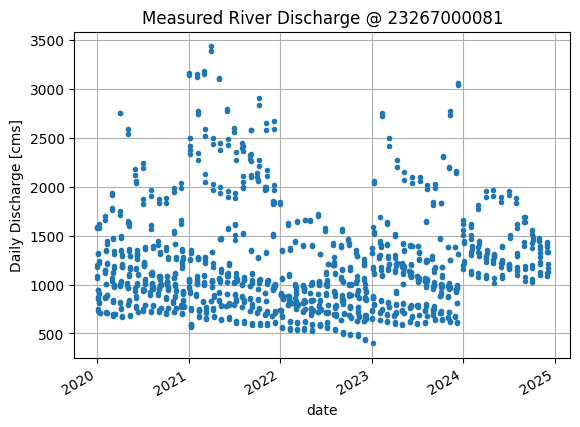

In [21]:
reach_id = 23267000081
df.sort_index(inplace=True)
df.loc[df.Reach_ID == reach_id]['Q_(m^3/s_daily)'].plot(grid=True,
                                                        linestyle='',
                                                        marker='.',
                                                        ylabel='Daily Discharge [cms]',
                                                        title=f'Measured River Discharge @ {reach_id}');

Next we'll collect modeled streamflow from the Science on Swords (SoS) project. First we need to connect to EarthData using the username and password stored in our `creds.py` file.

In [23]:
os.environ["EARTHDATA_USERNAME"] = creds.username
os.environ["EARTHDATA_PASSWORD"] = creds.password

# login to earthacces
auth = earthaccess.login(strategy="environment")

Search and locate the data granules that are available. Print some metadata about each one.

In [24]:
# Search and locate granules
granule_info = earthaccess.search_data(
    short_name="SWOT_L4_DAWG_SOS_DISCHARGE",
    temporal=("2023-01-01", "2025-01-01"),
)
i = 0
for collection in granule_info:
    print(f'Collection Index: {i}')
    print(collection['umm']['CollectionReference']['ShortName'])
    print(collection['umm']['DataGranule']['ArchiveAndDistributionInformation'][-1]['Name'])
    print(collection['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['BoundingRectangles'])
    print()
    i += 1

Collection Index: 0
SWOT_L4_DAWG_SOS_DISCHARGE
na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc
[{'WestBoundingCoordinate': -166.397, 'SouthBoundingCoordinate': 8.09, 'EastBoundingCoordinate': 8.09, 'NorthBoundingCoordinate': 82.311}]

Collection Index: 1
SWOT_L4_DAWG_SOS_DISCHARGE
na_sword_v16_SOS_unconstrained_0001_20240726T123358_results.nc
[{'WestBoundingCoordinate': -166.397, 'SouthBoundingCoordinate': 8.09, 'EastBoundingCoordinate': 8.09, 'NorthBoundingCoordinate': 82.311}]

Collection Index: 2
SWOT_L4_DAWG_SOS_DISCHARGE
eu_sword_v16_SOS_unconstrained_0001_20240726T123345_results.nc
[{'WestBoundingCoordinate': -21.794, 'SouthBoundingCoordinate': 25.382, 'EastBoundingCoordinate': 25.382, 'NorthBoundingCoordinate': 81.115}]

Collection Index: 3
SWOT_L4_DAWG_SOS_DISCHARGE
sa_sword_v16_SOS_unconstrained_0001_20240726T123343_priors.nc
[{'WestBoundingCoordinate': -81.139, 'SouthBoundingCoordinate': -52, 'EastBoundingCoordinate': -52, 'NorthBoundingCoordinate': 11.097}]

C

Open these files and print the NetCDF files that are stored for each granule. We'll use this information to determine which dataset to load into memory. To determine which file we should access we'll just look at the urls below to figure this out, this can be done more elegantly in the future.

In [26]:
files = earthaccess.open(granule_info)
files

QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc>,
 <File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240611T010141_priors.nc>,
 <File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240726T123358_results.nc>,
 <File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240726T123358_priors.nc>,
 <File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v16_SOS_unconstrained_0001_20240726T123345_results.nc>,
 <File-like 

We need to load two groups within the dataset; `reaches` and `hivdi`. The first contains information about the SWORD reaches that exist in the dataset and the latter is one of several discharge models that can be loaded.

In [27]:
%%time
print(f'Loading the "Reaches" group in file: {files[4].full_name}')
ds_reaches = xarray.open_dataset(files[4],
                                 group='reaches',
                                 engine='h5netcdf',
                                 decode_cf=False,    
                                 decode_times=False, 
                                 decode_coords=False)
ds_reaches

Loading File: <File-like object HTTPFileSystem, https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v16_SOS_unconstrained_0001_20240726T123345_results.nc>
CPU times: user 2.26 s, sys: 1.1 s, total: 3.36 s
Wall time: 1min 18s


<xarray.Dataset> Size: 9MB
Dimensions:       (num_reaches: 30363)
Dimensions without coordinates: num_reaches
Data variables:
    reach_id      (num_reaches) int64 243kB ...
    x             (num_reaches) float64 243kB ...
    y             (num_reaches) float64 243kB ...
    river_name    (num_reaches) <U65 8MB ...
    observations  (num_reaches) object 243kB ...
    time          (num_reaches) object 243kB ...

In [33]:
%%time
print(f'Loading the "hivdi" group in file: {files[4].full_name}')
ds_hivdi = xarray.open_dataset(files[4],
                           group='hivdi',
                           engine='h5netcdf',
                           decode_cf=False,    
                           decode_times=False, 
                           decode_coords=False,
                        )
ds_hivdi

Loading the "Reaches" group in file: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v16_SOS_unconstrained_0001_20240726T123345_results.nc
CPU times: user 1.86 s, sys: 895 ms, total: 2.76 s
Wall time: 57 s


<xarray.Dataset> Size: 972kB
Dimensions:  (num_reaches: 30363)
Dimensions without coordinates: num_reaches
Data variables:
    Q        (num_reaches) object 243kB ...
    A0       (num_reaches) float64 243kB ...
    beta     (num_reaches) float64 243kB ...
    alpha    (num_reaches) float64 243kB ...


Combine these datasets using the common num_reaches coordinate. This is necessary for us to select hidvi estimates by reach name or identifier.

In [35]:
ds_merged = xarray.combine_by_coords([ds_reaches, ds_hivdi])

Isolate the data corresponding with the reach we have observations for.

In [37]:
# use the mask to filter our data

mask = (ds_merged.reach_id == reach_id).compute()

ds_filtered = ds_merged.where(mask, drop=True)

d = ds_filtered.to_dataframe().reset_index().explode(['time', 'Q'])

Convert our 'time' column into datetime objects for pretty plotting.

In [38]:
reference_date = datetime(2000, 1, 1, 0, 0, 0)
d['datetime'] = d['time'].apply(lambda x: reference_date + timedelta(seconds=x))
d.set_index('datetime', inplace=True)

Create a plot containing the observed discharge that was collected from HydroShare and the `hivdi` strea

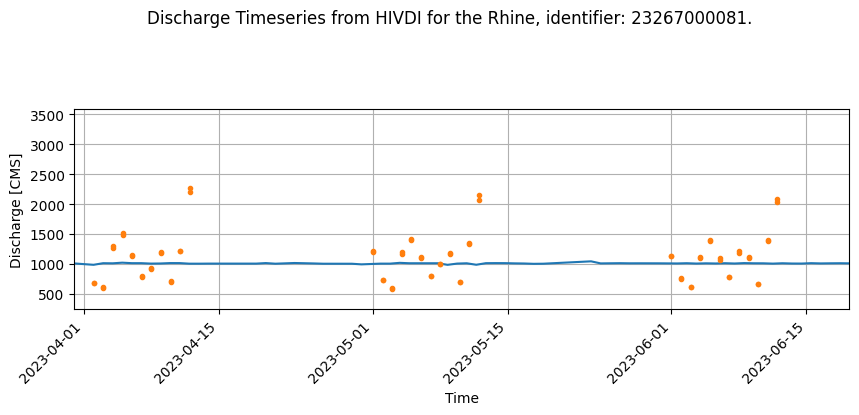

In [45]:
# Set up plot
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)

# Plot SoS data
d.Q.plot(ax=ax1)

# Plot Observed data
df.sort_index(inplace=True)
df.loc[df.Reach_ID == reach_id]['Q_(m^3/s_daily)'].plot(linestyle='', marker='.', ax=ax1);

# Define labels and title
ax1.set_ylabel('Discharge [CMS]');
ax1.set_xlabel('Time');

ax1.set_xlim(d.index[0], d.index[-1])

plt.xticks(rotation = 45);

plt.suptitle(f"Discharge Timeseries from HIVDI for the {ds_reaches.where(ds_reaches.reach_id == reach_id, drop=True).river_name.item()}, identifier: {reach_id}.");

plt.grid()
